In [ ]:
# Holiday-weighted re-train, manual CV & evaluation for RS and Optuna models 
# regarder sur le site de CRE
from catboost import CatBoostRegressor
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.model_selection import KFold
from sklearn.base import clone


frholidays = [
    "NewYearsDay",
    "ChristmasDay",
    "EasterMonday",
    "PentecostMonday",
    "FRAscension",
    "LaborDay",
    "FRFetDeLaVictoire1945",
    "FRBastilleDay",
    "FRArmisticeDay",
    "FRAssumptionVirginMary",
    "FRAllSaints"
]


X_tr_full = Xfs_train[selected_rfecv].copy()
X_tr_full['public_holidays'] = Xfs_train['public_holidays']
X_te_full = Xfs_test[selected_rfecv].copy()
X_te_full['public_holidays']  = Xfs_test['public_holidays']
y_tr_full = y_train.copy()
y_te_full = y_test.copy()


holiday_w, normal_w = 5, 1
w_tr = np.where(
    X_tr_full['public_holidays'].isin(frholidays),
    holiday_w,
    normal_w
)

# Train weighted models on full training set using only RFECV features
rs_w = CatBoostRegressor(
    **best_params_random,
    loss_function='RMSE', eval_metric='RMSE', random_seed=RANDOM_STATE,
    cat_features=cats_rfecv, verbose=0
)
opt_w = CatBoostRegressor(
    **best_params_optuna_focused,
    loss_function='RMSE', eval_metric='RMSE', random_seed=RANDOM_STATE,
    cat_features=cats_rfecv, verbose=0
)
# fit
rs_w.fit(
    X_tr_full[selected_rfecv],
    y_tr_full,
    sample_weight=w_tr
)
opt_w.fit(
    X_tr_full[selected_rfecv],
    y_tr_full,
    sample_weight=w_tr
)

# 5) Holiday-only evaluation on test set
mask_hol = X_te_full['public_holidays'].isin(frholidays)
X_hol = X_te_full.loc[mask_hol, selected_rfecv]
y_hol = y_te_full.loc[mask_hol]
print("\n--- Holiday-only Performance ---")
for name, m in [('RS-weighted', rs_w), ('Optuna-weighted', opt_w)]:
    pred = m.predict(X_hol)
    print(
        f"{name} → RMSE: {np.sqrt(mean_squared_error(y_hol, pred)):.2f}, "+
        f"MAPE: {mean_absolute_percentage_error(y_hol, pred)*100:.2f}%, "+
        f"R²: {r2_score(y_hol, pred):.3f}"
    )

# 6) Manual 5-Fold CV with sample weights
print("\n=== Manual 5-Fold CV Performance ===")
cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
for name, base_model in [('RS-weighted', rs_w), ('Optuna-weighted', opt_w)]:
    rmses, mapes, r2s = [], [], []
    for tr_idx, val_idx in cv.split(X_tr_full):
        X_tr, X_val = X_tr_full.iloc[tr_idx], X_tr_full.iloc[val_idx]
        y_tr, y_val = y_tr_full.iloc[tr_idx], y_tr_full.iloc[val_idx]
        w_tr_cv      = w_tr[tr_idx]
        model_cv     = clone(base_model)
        # fit 
        model_cv.fit(
            X_tr[selected_rfecv],
            y_tr,
            sample_weight=w_tr_cv
        )
        pred_val = model_cv.predict(X_val[selected_rfecv])
        rmses.append(np.sqrt(mean_squared_error(y_val, pred_val)))
        mapes.append(mean_absolute_percentage_error(y_val, pred_val)*100)
        r2s.append(r2_score(y_val, pred_val))
    print(
        f"{name} → RMSE: {np.mean(rmses):.2f}, "+
        f"MAPE: {np.mean(mapes):.2f}%, "+
        f"R²: {np.mean(r2s):.3f}"
    )




--- Holiday-only Performance ---
RS-weighted → RMSE: 15143.61, MAPE: 5.63%, R²: 0.993
Optuna-weighted → RMSE: 14832.57, MAPE: 6.88%, R²: 0.993

=== Manual 5-Fold CV Performance ===
RS-weighted → RMSE: 16829.78, MAPE: 4.74%, R²: 0.995
Optuna-weighted → RMSE: 16657.78, MAPE: 4.40%, R²: 0.995


In [34]:
# Holiday-weighted re-train, Leave-One-Holiday-Out & General 5-Fold CV for RS and Optuna models 
from catboost import CatBoostRegressor
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.base import clone
from sklearn.model_selection import KFold

# 1) French holidays list
frholidays = [
    "NewYearsDay",
    "ChristmasDay",
    "EasterMonday",
    "PentecostMonday",
    "FRAscension",
    "LaborDay",
    "FRFetDeLaVictoire1945",
    "FRBastilleDay",
    "FRArmisticeDay",
    "FRAssumptionVirginMary",
    "FRAllSaints"
]

X_tr_full = Xfs_train[selected_rfecv].copy()
X_tr_full['public_holidays'] = Xfs_train['public_holidays']
X_te_full = Xfs_test[selected_rfecv].copy()
X_te_full['public_holidays']  = Xfs_test['public_holidays']

y_tr_full = y_train.copy()
y_te_full = y_test.copy()


holiday_w, normal_w = 5, 1
w_tr = np.where(
    X_tr_full['public_holidays'].isin(frholidays),
    holiday_w,
    normal_w
)


rs_w = CatBoostRegressor(
    **best_params_random,
    loss_function='RMSE', eval_metric='RMSE', random_seed=RANDOM_STATE,
    cat_features=cats_rfecv, verbose=0
)
opt_w = CatBoostRegressor(
    **best_params_optuna_focused,
    loss_function='RMSE', eval_metric='RMSE', random_seed=RANDOM_STATE,
    cat_features=cats_rfecv, verbose=0
)


rs_w.fit(
    X_tr_full[selected_rfecv],
    y_tr_full,
    sample_weight=w_tr
)
opt_w.fit(
    X_tr_full[selected_rfecv],
    y_tr_full,
    sample_weight=w_tr
)


mask_hol = X_te_full['public_holidays'].isin(frholidays)
X_hol     = X_te_full.loc[mask_hol, selected_rfecv]
y_hol     = y_te_full.loc[mask_hol]
print("\n--- Holiday-only Performance on Test Set ---")
for name, m in [('RS-weighted', rs_w), ('Optuna-weighted', opt_w)]:
    pred = m.predict(X_hol)
    print(
        f"{name} → RMSE: {np.sqrt(mean_squared_error(y_hol, pred)):.2f}, "+
        f"MAPE: {mean_absolute_percentage_error(y_hol, pred)*100:.2f}%, "+
        f"R²: {r2_score(y_hol, pred):.3f}"
    )

# 7) Leave-One-Holiday-Out CV on training holidays (RMSE & MAPE only)
print(" LOO CV Performance (Holidays Only)")
hol_idx = X_tr_full.index[X_tr_full['public_holidays'].isin(frholidays)]
for name, base_model in [('RS-weighted', rs_w), ('Optuna-weighted', opt_w)]:
    rmses, mapes = [], [] 
    for idx in hol_idx:
        train_idx = X_tr_full.index.difference([idx])
        val_idx   = [idx]
        X_tr_cv = X_tr_full.loc[train_idx, selected_rfecv]
        y_tr_cv = y_tr_full.loc[train_idx]
        w_tr_cv = w_tr[np.isin(X_tr_full.index, train_idx)]
        X_val_cv = X_tr_full.loc[val_idx, selected_rfecv]
        y_val_cv = y_tr_full.loc[val_idx]

        model_cv = clone(base_model)
        model_cv.fit(
            X_tr_cv,
            y_tr_cv,
            sample_weight=w_tr_cv
        )
        pred_cv = model_cv.predict(X_val_cv)
        rmses.append(np.sqrt(mean_squared_error(y_val_cv, pred_cv)))
        mapes.append(mean_absolute_percentage_error(y_val_cv, pred_cv)*100)
    print(
        f"{name} LOO-holidays → RMSE: {np.mean(rmses):.2f}, "+
        f"MAPE: {np.mean(mapes):.2f}%"
    )


print("\n 5-Fold CV Performance on weighted models")
cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
for name, base_model in [('RS-weighted', rs_w), ('Optuna-weighted', opt_w)]:
    rmses, mapes, r2s = [], [], []
    for tr_idx, val_idx in cv.split(X_tr_full):
        X_tr_cv = X_tr_full.iloc[tr_idx][selected_rfecv]
        y_tr_cv = y_tr_full.iloc[tr_idx]
        w_cv    = w_tr[tr_idx]
        X_val_cv = X_tr_full.iloc[val_idx][selected_rfecv]
        y_val_cv = y_tr_full.iloc[val_idx]

        model_cv = clone(base_model)
        model_cv.fit(
            X_tr_cv,
            y_tr_cv,
            sample_weight=w_cv
        )
        pred_val = model_cv.predict(X_val_cv)
        rmses.append(np.sqrt(mean_squared_error(y_val_cv, pred_val)))
        mapes.append(mean_absolute_percentage_error(y_val_cv, pred_val)*100)
        r2s.append(r2_score(y_val_cv, pred_val))
    print(
        f"{name} 5-Fold CV → RMSE: {np.mean(rmses):.2f}, "+
        f"MAPE: {np.mean(mapes):.2f}%, "+
        f"R²: {np.mean(r2s):.3f}"
    )



--- Holiday-only Performance on Test Set ---
RS-weighted → RMSE: 15143.61, MAPE: 5.63%, R²: 0.993
Optuna-weighted → RMSE: 14832.57, MAPE: 6.88%, R²: 0.993
 LOO CV Performance (Holidays Only)
RS-weighted LOO-holidays → RMSE: 15968.04, MAPE: 9.46%
Optuna-weighted LOO-holidays → RMSE: 16133.85, MAPE: 9.11%

 5-Fold CV Performance on weighted models
RS-weighted 5-Fold CV → RMSE: 16829.78, MAPE: 4.74%, R²: 0.995
Optuna-weighted 5-Fold CV → RMSE: 16657.78, MAPE: 4.40%, R²: 0.995


In [35]:
## %%  Holiday‐Weight Sensitivity: LOO‐Holidays RMSE & MAPE vs Holiday Weight  ⸺
#import numpy as np
#import matplotlib.pyplot as plt
#from catboost import CatBoostRegressor
#from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
#from sklearn.base import clone
#
## French holidays list
#frholidays = [
#    "NewYearsDay", "ChristmasDay", "EasterMonday", "PentecostMonday",
#    "FRAscension", "LaborDay", "FRFetDeLaVictoire1945", "FRBastilleDay",
#    "FRArmisticeDay", "FRAssumptionVirginMary", "FRAllSaints"
#]
#
## Prepare full train frame & flags
#X_full = Xfs_train[selected_rfecv].copy()
#X_full['public_holidays'] = Xfs_train['public_holidays']
#y_full = y_train.copy()
#
## Define holiday weights to test
#weights = [1, 2, 3, 4, 5]
#
## Storage for results
#results = {
#    'RS': {'rmse': [], 'mape': []},
#    'Optuna': {'rmse': [], 'mape': []}
#}
#
## Loop over weights
#for w in weights:
#    # build sample weights array
#    sample_w = np.where(
#        X_full['public_holidays'].isin(frholidays),
#        w, 1
#    )
#    # instantiate fresh models
#    rs_model = CatBoostRegressor(
#        **best_params_random,
#        loss_function='RMSE', eval_metric='RMSE',
#        random_seed=RANDOM_STATE,
#        cat_features=cats_rfecv, verbose=0
#    )
#    opt_model = CatBoostRegressor(
#        **best_params_optuna_focused,
#        loss_function='RMSE', eval_metric='RMSE',
#        random_seed=RANDOM_STATE,
#        cat_features=cats_rfecv, verbose=0
#    )
#    # fit on full training (only RFECV features)
#    rs_model.fit(X_full[selected_rfecv], y_full, sample_weight=sample_w)
#    opt_model.fit(X_full[selected_rfecv], y_full, sample_weight=sample_w)
#
#    # Leave-One-Holiday-Out on training holidays
#    hol_idx = X_full.index[X_full['public_holidays'].isin(frholidays)]
#    rs_rmses, rs_mapes = [], []
#    opt_rmses, opt_mapes = [], []
#
#    for idx in hol_idx:
#        # train on all except this holiday
#        train_idx = X_full.index.difference([idx])
#        X_tr = X_full.loc[train_idx, selected_rfecv]
#        y_tr = y_full.loc[train_idx]
#        w_tr = sample_w[np.isin(X_full.index, train_idx)]
#
#        # val on the single holiday
#        X_val = X_full.loc[[idx], selected_rfecv]
#        y_val = y_full.loc[[idx]]
#
#        # RS
#        m_rs = clone(rs_model)
#        m_rs.fit(X_tr, y_tr, sample_weight=w_tr)
#        pred_rs = m_rs.predict(X_val)
#        rs_rmses.append(np.sqrt(mean_squared_error(y_val, pred_rs)))
#        rs_mapes.append(mean_absolute_percentage_error(y_val, pred_rs) * 100)
#
#        # Optuna
#        m_opt = clone(opt_model)
#        m_opt.fit(X_tr, y_tr, sample_weight=w_tr)
#        pred_opt = m_opt.predict(X_val)
#        opt_rmses.append(np.sqrt(mean_squared_error(y_val, pred_opt)))
#        opt_mapes.append(mean_absolute_percentage_error(y_val, pred_opt) * 100)
#
#    # store mean metrics
#    results['RS']['rmse'].append(np.mean(rs_rmses))
#    results['RS']['mape'].append(np.mean(rs_mapes))
#    results['Optuna']['rmse'].append(np.mean(opt_rmses))
#    results['Optuna']['mape'].append(np.mean(opt_mapes))
#
## Plotting LOO-Holidays metrics
#fig, ax1 = plt.subplots(figsize=(8,5))
#ax2 = ax1.twinx()
#
## RS curves
#ax1.plot(weights, results['RS']['rmse'], 'o-', label='RS LOO RMSE')
#ax2.plot(weights, results['RS']['mape'], 's--', label='RS LOO MAPE')
#
## Optuna curves
#ax1.plot(weights, results['Optuna']['rmse'], 'o-', label='Optuna LOO RMSE', color='C2')
#ax2.plot(weights, results['Optuna']['mape'], 's--', label='Optuna LOO MAPE', color='C3')
#
#ax1.set_xlabel('Holiday Sample Weight')
#ax1.set_ylabel('LOO-Holidays RMSE')
#ax2.set_ylabel('LOO-Holidays MAPE (%)')
#ax1.set_xticks(weights)
#lines1, labels1 = ax1.get_legend_handles_labels()
#lines2, labels2 = ax2.get_legend_handles_labels()
#ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
#plt.title('LOO-Holidays RMSE & MAPE vs Holiday Weight')
#plt.tight_layout()
#plt.show()
#
## 9) Overall 3-Fold CV Performance vs Weight
#from sklearn.model_selection import KFold
#
## Prepare storage for CV results
#results['RS']['cv_rmse'] = []
#results['RS']['cv_mape'] = []
#results['Optuna']['cv_rmse'] = []
#results['Optuna']['cv_mape'] = []
#
#kf3 = KFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)
#for w in weights:
#    # rebuild sample weights
#    sample_w = np.where(
#        X_full['public_holidays'].isin(frholidays),
#        w, 1
#    )
#    # fresh models
#    rs_model = CatBoostRegressor(
#        **best_params_random,
#        loss_function='RMSE', eval_metric='RMSE',
#        random_seed=RANDOM_STATE,
#        cat_features=cats_rfecv, verbose=0
#    )
#    opt_model = CatBoostRegressor(
#        **best_params_optuna_focused,
#        loss_function='RMSE', eval_metric='RMSE',
#        random_seed=RANDOM_STATE,
#        cat_features=cats_rfecv, verbose=0
#    )
#    rmse_folds_rs, mape_folds_rs = [], []
#    rmse_folds_opt, mape_folds_opt = [], []
#    # 3-fold CV
#    for tr_i, val_i in kf3.split(X_full):
#        X_tr, X_val = X_full.iloc[tr_i][selected_rfecv], X_full.iloc[val_i][selected_rfecv]
#        y_tr, y_val = y_full.iloc[tr_i], y_full.iloc[val_i]
#        w_tr_cv = sample_w[tr_i]
#        # RS
#        m_rs = clone(rs_model)
#        m_rs.fit(X_tr, y_tr, sample_weight=w_tr_cv)
#        pred_rs = m_rs.predict(X_val)
#        rmse_folds_rs.append(np.sqrt(mean_squared_error(y_val, pred_rs)))
#        mape_folds_rs.append(mean_absolute_percentage_error(y_val, pred_rs)*100)
#        # Optuna
#        m_opt = clone(opt_model)
#        m_opt.fit(X_tr, y_tr, sample_weight=w_tr_cv)
#        pred_opt = m_opt.predict(X_val)
#        rmse_folds_opt.append(np.sqrt(mean_squared_error(y_val, pred_opt)))
#        mape_folds_opt.append(mean_absolute_percentage_error(y_val, pred_opt)*100)
#    # store mean
#    results['RS']['cv_rmse'].append(np.mean(rmse_folds_rs))
#    results['RS']['cv_mape'].append(np.mean(mape_folds_rs))
#    results['Optuna']['cv_rmse'].append(np.mean(rmse_folds_opt))
#    results['Optuna']['cv_mape'].append(np.mean(mape_folds_opt))
#
## Plotting 3-Fold CV metrics
#fig, ax1 = plt.subplots(figsize=(8,5))
#ax2 = ax1.twinx()
#
## RS
#ax1.plot(weights, results['RS']['cv_rmse'], 'o-', label='RS CV RMSE')
#ax2.plot(weights, results['RS']['cv_mape'], 's--', label='RS CV MAPE')
## Optuna
#ax1.plot(weights, results['Optuna']['cv_rmse'], 'o-', label='Optuna CV RMSE', color='C2')
#ax2.plot(weights, results['Optuna']['cv_mape'], 's--', label='Optuna CV MAPE', color='C3')
#
#ax1.set_xlabel('Holiday Sample Weight')
#ax1.set_ylabel('3-Fold CV RMSE')
#ax2.set_ylabel('3-Fold CV MAPE (%)')
#ax1.set_xticks(weights)
#lines1, labels1 = ax1.get_legend_handles_labels()
#lines2, labels2 = ax2.get_legend_handles_labels()
#ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
#plt.title('3-Fold CV RMSE & MAPE vs Holiday Weight')
#plt.tight_layout()
#plt.show()
## %%


weight = 2 appears to be the best compromise

In [36]:
## %%  Oversample holidays in training set & eval  ⸺
#from catboost import CatBoostRegressor, Pool
#import numpy as np
#from sklearn.utils import shuffle
#from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
#
#
#OS_FACTOR = 5
#
## 2) Make full RFECV train frame with holiday flag
#X_train_os_full = X_tr_full[selected_rfecv].copy()
#X_train_os_full['is_hol'] = X_tr_full['public_holidays'].isin(frholidays).astype(int)
#y_train_os_full = y_tr_full.copy()
#
## 3) Split out holiday subset
#mask = X_train_os_full['is_hol'] == 1
#X_hol_subset = X_train_os_full.loc[mask, selected_rfecv]
#y_hol_subset = y_train_os_full.loc[mask]
#
## 4) Build oversampled train set by concatenation
#X_os = pd.concat(
#    [X_train_os_full[selected_rfecv]] +
#    [X_hol_subset[selected_rfecv]] * (OS_FACTOR - 1),
#    axis=0
#)
#y_os = pd.concat(
#    [y_train_os_full] +
#    [y_hol_subset] * (OS_FACTOR - 1),
#    axis=0
#)
#
#
#X_train_os, y_train_os = shuffle(X_os, y_os, random_state=RANDOM_STATE)
#
#
#rs_os = CatBoostRegressor(
#    **best_params_random,
#    loss_function='RMSE',
#    eval_metric='RMSE',
#    random_seed=RANDOM_STATE,
#    cat_features=cats_rfecv,
#    verbose=0
#)
#opt_os = CatBoostRegressor(
#    **best_params_optuna_focused,
#    loss_function='RMSE',
#    eval_metric='RMSE',
#    random_seed=RANDOM_STATE,
#    cat_features=cats_rfecv,
#    verbose=0
#)
#
#
#rs_os.fit(X_train_os, y_train_os)
#opt_os.fit(X_train_os, y_train_os)
#
#
#mask_test_hol = X_te_full['public_holidays'].isin(frholidays)
#X_test_hol    = X_te_full.loc[mask_test_hol, selected_rfecv]
#y_test_hol    = y_te_full.loc[mask_test_hol]
#
#print("\n--- Oversampled Holiday Test Performance ---")
#for name, m in [('RS-Oversampled', rs_os), ('Optuna-Oversampled', opt_os)]:
#    pred = m.predict(X_test_hol)
#    print(
#        f"{name} → RMSE: {np.sqrt(mean_squared_error(y_test_hol, pred)):.2f}, "+
#        f"MAPE: {mean_absolute_percentage_error(y_test_hol, pred)*100:.2f}%, "+
#        f"R²: {r2_score(y_test_hol, pred):.3f}"
#    )
#
#
#from sklearn.model_selection import KFold
#kf3 = KFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)
#
#print("\n=== 3-Fold CV on Oversampled Data ===")
#for name, base_model in [('RS-Oversampled', rs_os), ('Optuna-Oversampled', opt_os)]:
#    rmses, mapes = [], []
#    for tr_i, val_i in kf3.split(X_train_os):
#        X_tr, X_val = X_train_os.iloc[tr_i], X_train_os.iloc[val_i]
#        y_tr, y_val = y_train_os.iloc[tr_i], y_train_os.iloc[val_i]
#        m_cv = clone(base_model)
#        m_cv.fit(X_tr, y_tr)
#        p = m_cv.predict(X_val)
#        rmses.append(np.sqrt(mean_squared_error(y_val, p)))
#        mapes.append(mean_absolute_percentage_error(y_val, p)*100)
#    print(f"{name} → RMSE: {np.mean(rmses):.2f}, MAPE: {np.mean(mapes):.2f}%")
## %%


In [37]:
## %%  Oversampling Sensitivity Analysis & Plots  ⸺
#import pandas as pd
#import numpy as np
#import matplotlib.pyplot as plt
#from sklearn.utils import shuffle
#from sklearn.model_selection import KFold
#from catboost import CatBoostRegressor
#from sklearn.base import clone
#from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
#
## 1) French holidays list
#frholidays = [
#    "NewYearsDay","ChristmasDay","EasterMonday","PentecostMonday",
#    "FRAscension","LaborDay","FRFetDeLaVictoire1945","FRBastilleDay",
#    "FRArmisticeDay","FRAssumptionVirginMary","FRAllSaints"
#]
#
## 2) Prepare full RFECV train & test frames
##    (assumes X_tr_full, X_te_full, y_tr_full, y_te_full already exist)
## X_tr_full has columns selected_rfecv + 'public_holidays'
## X_te_full likewise, y_tr_full = y_train, y_te_full = y_test
#
## 3) Define oversampling factors to test
#os_factors = [1, 2, 3, 4, 5, 8, 10, 15]
#
## 4) Build holiday‐only test set once
#mask_te_hol = X_te_full['public_holidays'].isin(frholidays)
#X_test_hol  = X_te_full.loc[mask_te_hol, selected_rfecv]
#y_test_hol  = y_te_full.loc[mask_te_hol]
#
## 5) Storage for all metrics
#records = {
#    'factor': [],
#    'RS_test_rmse': [], 'RS_test_mape': [],
#    'Opt_test_rmse': [], 'Opt_test_mape': [],
#    'RS_cv_rmse': [],   'RS_cv_mape': [],
#    'Opt_cv_rmse': [],  'Opt_cv_mape': []
#}
#
## 6) Loop over oversampling factors
#for f in os_factors:
#    # a) build oversampled train set via concat
#    #    replicate only the holiday rows (public_holidays ∈ frholidays)
#    X_hol = X_tr_full[X_tr_full['public_holidays'].isin(frholidays)][selected_rfecv]
#    y_hol = y_tr_full[X_tr_full['public_holidays'].isin(frholidays)]
#    X_os = pd.concat([X_tr_full[selected_rfecv]] + [X_hol] * (f - 1), axis=0)
#    y_os = pd.concat([y_tr_full]           + [y_hol] * (f - 1), axis=0)
#    X_os, y_os = shuffle(X_os, y_os, random_state=RANDOM_STATE)
#
#    # b) instantiate models with your tuned settings
#    rs_model = CatBoostRegressor(
#        **best_params_random,
#        loss_function='RMSE', eval_metric='RMSE',
#        random_seed=RANDOM_STATE, cat_features=cats_rfecv, verbose=0
#    )
#    opt_model = CatBoostRegressor(
#        **best_params_optuna_focused,
#        loss_function='RMSE', eval_metric='RMSE',
#        random_seed=RANDOM_STATE, cat_features=cats_rfecv, verbose=0
#    )
#
#    # c) fit on oversampled training data
#    rs_model.fit(X_os, y_os)
#    opt_model.fit(X_os, y_os)
#
#    # d) evaluate on holiday‐only test set
#    pred_rs = rs_model.predict(X_test_hol)
#    pred_opt = opt_model.predict(X_test_hol)
#    rs_trmse = np.sqrt(mean_squared_error(y_test_hol, pred_rs))
#    rs_tmape = mean_absolute_percentage_error(y_test_hol, pred_rs) * 100
#    opt_trmse = np.sqrt(mean_squared_error(y_test_hol, pred_opt))
#    opt_tmape = mean_absolute_percentage_error(y_test_hol, pred_opt) * 100
#
#    # e) 3‐fold CV on oversampled data (whole set)
#    kf3 = KFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)
#    rs_cvres, rs_cvmap = [], []
#    opt_cvres, opt_cvmap = [], []
#    for tr_i, val_i in kf3.split(X_os):
#        X_tr, y_tr = X_os.iloc[tr_i], y_os.iloc[tr_i]
#        X_val, y_val = X_os.iloc[val_i], y_os.iloc[val_i]
#
#        m_rs = clone(rs_model)
#        m_rs.fit(X_tr, y_tr)
#        p_rs = m_rs.predict(X_val)
#        rs_cvres.append(np.sqrt(mean_squared_error(y_val, p_rs)))
#        rs_cvmap.append(mean_absolute_percentage_error(y_val, p_rs) * 100)
#
#        m_opt = clone(opt_model)
#        m_opt.fit(X_tr, y_tr)
#        p_opt = m_opt.predict(X_val)
#        opt_cvres.append(np.sqrt(mean_squared_error(y_val, p_opt)))
#        opt_cvmap.append(mean_absolute_percentage_error(y_val, p_opt) * 100)
#
#    # f) record means
#    records['factor'].append(f)
#    records['RS_test_rmse'].append(rs_trmse)
#    records['RS_test_mape'].append(rs_tmape)
#    records['Opt_test_rmse'].append(opt_trmse)
#    records['Opt_test_mape'].append(opt_tmape)
#    records['RS_cv_rmse'].append(np.mean(rs_cvres))
#    records['RS_cv_mape'].append(np.mean(rs_cvmap))
#    records['Opt_cv_rmse'].append(np.mean(opt_cvres))
#    records['Opt_cv_mape'].append(np.mean(opt_cvmap))
#
## 7) Convert to DataFrame
#df_rec = pd.DataFrame(records)
#
## 8) Plotting
#fig, axes = plt.subplots(2, 1, figsize=(8, 12))
## ─ Holiday‐Test Performance ─────────────────────────────────────────
#ax1 = axes[0]
#ax2 = ax1.twinx()
#ax1.plot(df_rec['factor'], df_rec['RS_test_rmse'], 'o-', label='RS RMSE')
#ax1.plot(df_rec['factor'], df_rec['Opt_test_rmse'], 'o-', label='Optuna RMSE', color='C2')
#ax2.plot(df_rec['factor'], df_rec['RS_test_mape'], 's--', label='RS MAPE', color='C3')
#ax2.plot(df_rec['factor'], df_rec['Opt_test_mape'], 's--', label='Optuna MAPE', color='C4')
#ax1.set_xlabel('Oversampling Factor')
#ax1.set_ylabel('Holiday Test RMSE')
#ax2.set_ylabel('Holiday Test MAPE (%)')
#h1, l1 = ax1.get_legend_handles_labels()
#h2, l2 = ax2.get_legend_handles_labels()
#ax1.legend(h1 + h2, l1 + l2, loc='upper left')
#ax1.set_title('Holiday‐Only Test Performance vs Oversampling Factor')
#
## ─ 3‐Fold CV Performance ────────────────────────────────────────────
#ax3 = axes[1]
#ax4 = ax3.twinx()
#ax3.plot(df_rec['factor'], df_rec['RS_cv_rmse'], 'o-', label='RS CV RMSE')
#ax3.plot(df_rec['factor'], df_rec['Opt_cv_rmse'], 'o-', label='Optuna CV RMSE', color='C2')
#ax4.plot(df_rec['factor'], df_rec['RS_cv_mape'], 's--', label='RS CV MAPE', color='C3')
#ax4.plot(df_rec['factor'], df_rec['Opt_cv_mape'], 's--', label='Optuna CV MAPE', color='C4')
#ax3.set_xlabel('Oversampling Factor')
#ax3.set_ylabel('3-Fold CV RMSE')
#ax4.set_ylabel('3-Fold CV MAPE (%)')
#h3, l3 = ax3.get_legend_handles_labels()
#h4, l4 = ax4.get_legend_handles_labels()
#ax3.legend(h3 + h4, l3 + l4, loc='upper left')
#ax3.set_title('3‐Fold CV Performance vs Oversampling Factor')
#
#plt.tight_layout()
#plt.show()
# %%


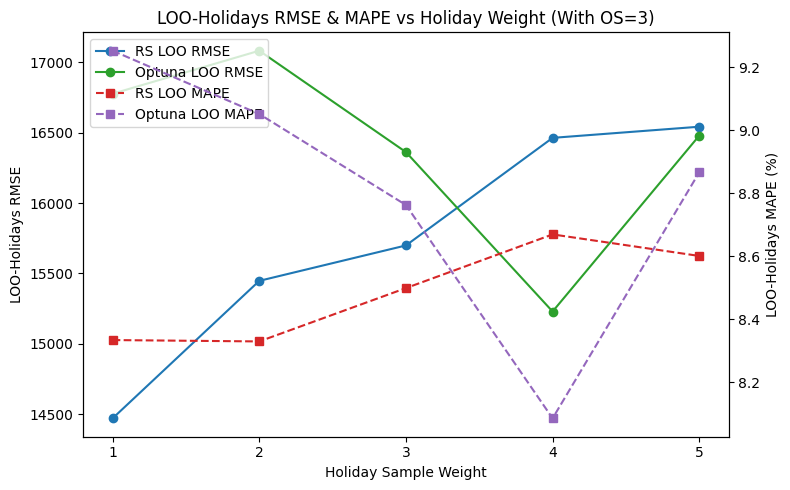

In [38]:
# OS = 3, weight sensitivity on LOO and K fold
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.base import clone


frholidays = [
    "NewYearsDay","ChristmasDay","EasterMonday","PentecostMonday",
    "FRAscension","LaborDay","FRFetDeLaVictoire1945","FRBastilleDay",
    "FRArmisticeDay","FRAssumptionVirginMary","FRAllSaints"
]


X_base = Xfs_train[selected_rfecv].copy()
X_base['public_holidays'] = Xfs_train['public_holidays']
X_base['orig_idx'] = X_base.index
y_base = y_train.copy()


OS_FACTOR = 3
hol_mask = X_base['public_holidays'].isin(frholidays)
X_hol = X_base.loc[hol_mask]
y_hol = y_base.loc[hol_mask]

X_os = pd.concat([X_base] + [X_hol]*(OS_FACTOR-1), axis=0).reset_index(drop=True)
y_os = pd.concat([y_base] + [y_hol]*(OS_FACTOR-1), axis=0).reset_index(drop=True)


weights = [1, 2, 3, 4, 5]

loo = {'RS': {'rmse':[], 'mape':[]}, 'Optuna': {'rmse':[], 'mape':[]}}

for w in weights:

    sw = np.where(X_os['public_holidays'].isin(frholidays), w, 1)
    
    rs = CatBoostRegressor(
        **best_params_random,
        loss_function='RMSE', eval_metric='RMSE',
        random_seed=RANDOM_STATE,
        cat_features=cats_rfecv, verbose=0
    )
    opt = CatBoostRegressor(
        **best_params_optuna_focused,
        loss_function='RMSE', eval_metric='RMSE',
        random_seed=RANDOM_STATE,
        cat_features=cats_rfecv, verbose=0
    )
    

    rs.fit(X_os[selected_rfecv], y_os, sample_weight=sw)
    opt.fit(X_os[selected_rfecv], y_os, sample_weight=sw)
    
    # LOO on the original holidays
    orig_hol_idxs = X_base.index[ X_base['public_holidays'].isin(frholidays) ]
    rs_errs, rs_maps = [], []
    op_errs, op_maps = [], []
    
    for idx in orig_hol_idxs:
        # train on all OS rows whose orig_idx ≠ idx
        train_mask = X_os['orig_idx'] != idx
        X_tr = X_os.loc[train_mask, selected_rfecv]
        y_tr = y_os[train_mask]
        sw_tr = sw[train_mask]
        
        # validate on the single original holiday row
        X_val = X_base.loc[[idx], selected_rfecv]
        y_val = y_base.loc[[idx]]
        
        mrs = clone(rs)
        mrs.fit(X_tr, y_tr, sample_weight=sw_tr)
        p_rs = mrs.predict(X_val)
        rs_errs.append(np.sqrt(mean_squared_error(y_val, p_rs)))
        rs_maps.append(mean_absolute_percentage_error(y_val, p_rs)*100)
        
        mop = clone(opt)
        mop.fit(X_tr, y_tr, sample_weight=sw_tr)
        p_op = mop.predict(X_val)
        op_errs.append(np.sqrt(mean_squared_error(y_val, p_op)))
        op_maps.append(mean_absolute_percentage_error(y_val, p_op)*100)
    
    loo['RS']['rmse'].append(np.mean(rs_errs))
    loo['RS']['mape'].append(np.mean(rs_maps))
    loo['Optuna']['rmse'].append(np.mean(op_errs))
    loo['Optuna']['mape'].append(np.mean(op_maps))

# 6) Plot LOO-Holidays RMSE & MAPE vs Holiday Weight (with OS×3)
fig, ax1 = plt.subplots(figsize=(8,5))
ax2 = ax1.twinx()

ax1.plot(weights, loo['RS']['rmse'],  'o-', label='RS LOO RMSE')
ax1.plot(weights, loo['Optuna']['rmse'], 'o-', color='C2', label='Optuna LOO RMSE')
ax2.plot(weights, loo['RS']['mape'],  's--', color='C3', label='RS LOO MAPE')
ax2.plot(weights, loo['Optuna']['mape'], 's--', color='C4', label='Optuna LOO MAPE')

ax1.set_xlabel('Holiday Sample Weight')
ax1.set_ylabel('LOO-Holidays RMSE')
ax2.set_ylabel('LOO-Holidays MAPE (%)')
ax1.set_xticks(weights)
h1,l1 = ax1.get_legend_handles_labels()
h2,l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, loc='upper left')
plt.title('LOO-Holidays RMSE & MAPE vs Holiday Weight (With OS=3)')
plt.tight_layout()
plt.show()


In [39]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np


OS_FACTOR = 3
hol_mask   = Xfs_train['public_holidays'].isin(frholidays)
X_hol      = Xfs_train[hol_mask]
y_hol      = y_train[hol_mask]

X_os = pd.concat([Xfs_train] + [X_hol]*(OS_FACTOR-1), axis=0).reset_index(drop=True)
y_os = pd.concat([y_train]   + [y_hol]*(OS_FACTOR-1), axis=0).reset_index(drop=True)


weight_value = 5
sw = np.where(
    X_os['public_holidays'].isin(frholidays),
    weight_value,
    1             
)


base_cb = CatBoostRegressor(
    loss_function='RMSE',
    eval_metric='RMSE',
    random_seed=RANDOM_STATE,
    cat_features=cats_rfecv,
    verbose=0
)


param_dist = {
    'iterations': randint(1000, 2500),
    'learning_rate': uniform(0.01, 0.2),
    'depth': randint(2, 8),
    'l2_leaf_reg': uniform(1, 5),
    'border_count': randint(126, 256),
    'per_float_feature_quantization': quantisation_candidates,
    'monotone_constraints':             monotone_constraint_candidates,
    }

rs_cv = RandomizedSearchCV(
    estimator=base_cb,
    param_distributions=param_dist,
    n_iter=200,
    cv=5,
    scoring='neg_root_mean_squared_error',
    random_state=RANDOM_STATE,
    verbose=1
)


rs_cv.fit(
    X_os[selected_rfecv], 
    y_os, 
    sample_weight=sw
)

print("Best parameters:", rs_cv.best_params_)


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


KeyboardInterrupt: 

In [40]:
from sklearn.model_selection import train_test_split

frholidays = [
    "NewYearsDay","ChristmasDay","EasterMonday","PentecostMonday",
    "FRAscension","LaborDay","FRFetDeLaVictoire1945","FRBastilleDay",
    "FRArmisticeDay","FRAssumptionVirginMary","FRAllSaints"
]


X_base = Xfs_train[selected_rfecv].copy()
X_base['public_holidays'] = Xfs_train['public_holidays']
y_base = y_train.copy()

# collapse all non‐holidays into “NotAHoliday”
stratify_labels = X_base['public_holidays'].apply(
    lambda x: x if x in frholidays else "NotAHoliday"
)


X_tr, X_te, y_tr, y_te = train_test_split(
    X_base[selected_rfecv],  # just your RFECV columns
    y_base, 
    test_size=0.2,
    random_state=42,
    stratify=stratify_labels
)


print("Holidays in test set:",
      sorted(X_te
             .assign(holiday=X_te.index.map(lambda i: X_base.loc[i,'public_holidays']))
             ['holiday']
             .unique()))


Holidays in test set: ['BoxingDay', 'ChristmasDay', 'EasterMonday', 'FRAllSaints', 'FRArmisticeDay', 'FRAscension', 'FRAssumptionVirginMary', 'FRBastilleDay', 'FRFetDeLaVictoire1945', 'GoodFriday', 'LaborDay', 'NewYearsDay', 'NotAHoliday', 'PentecostMonday']


In [42]:
import json
import numpy as np
import pandas as pd
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split


with open('params/best_params_hol.json','r') as f:
    best_rs_tuned = json.load(f)


frholidays = [
    "NewYearsDay","ChristmasDay","EasterMonday","PentecostMonday",
    "FRAscension","LaborDay","FRFetDeLaVictoire1945","FRBastilleDay",
    "FRArmisticeDay","FRAssumptionVirginMary","FRAllSaints"
]


X_base = Xfs_train[selected_rfecv].copy()
X_base['public_holidays'] = Xfs_train['public_holidays']
y_base = y_train.copy()


stratify_labels = X_base['public_holidays'].apply(
    lambda x: x if x in frholidays else "NotAHoliday"
)


X_tr_base, X_te_base, y_tr_base, y_te_base = train_test_split(
    X_base, y_base,
    test_size=0.2,
    random_state=42,
    stratify=stratify_labels
)


OS = 3
mask_tr = X_tr_base['public_holidays'].isin(frholidays)
X_hol_tr = X_tr_base.loc[mask_tr]
y_hol_tr = y_tr_base.loc[mask_tr]

X_tr_os = pd.concat([X_tr_base] + [X_hol_tr]*(OS-1), axis=0).reset_index(drop=True)
y_tr_os = pd.concat([y_tr_base] + [y_hol_tr]*(OS-1), axis=0).reset_index(drop=True)


sw = np.where(X_tr_os['public_holidays'].isin(frholidays), 5, 1)

# slice out the holiday‐only slice 
mask_te_hol = X_te_base['public_holidays'].isin(frholidays)
X_te_hol    = X_te_base.loc[mask_te_hol,    selected_rfecv]
y_te_hol    = y_te_base.loc[mask_te_hol]

# full‐test‐fold features + target
X_te_full = X_te_base[selected_rfecv]
y_te_full = y_te_base


model = CatBoostRegressor(
    loss_function='RMSE',
    eval_metric='RMSE',
    custom_metric=['MAPE','R2'],
    random_seed=RANDOM_STATE,
    cat_features=cats_rfecv,
    verbose=0,
    **best_rs_tuned
)

model.fit(
    X_tr_os[selected_rfecv], 
    y_tr_os, 
    sample_weight=sw,
    eval_set=[
      (X_te_full, y_te_full),   # full test set
      (X_te_hol,  y_te_hol )    # the holiday‐only slice
    ],
    use_best_model=True,
    plot=True
)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [43]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error


mask_te_hol = X_te_base['public_holidays'].isin(frholidays)

X_hol = X_te_base.loc[mask_te_hol, selected_rfecv]
y_hol = y_te_base.loc[mask_te_hol]

preds_hol = model.predict(X_hol)


df_hol = pd.DataFrame({
    'holiday': X_te_base.loc[mask_te_hol, 'public_holidays'].astype(str),
    'y_true':  y_hol.values,
    'y_pred':  preds_hol
})


per_holiday_eval = df_hol.groupby('holiday').apply(
    lambda g: pd.Series({
        'rmse': np.sqrt(mean_squared_error(g['y_true'], g['y_pred'])),
        'mape': mean_absolute_percentage_error(g['y_true'], g['y_pred'])*100
    })
)

per_holiday_eval


,rmse,mape
holiday,,
ChristmasDay,24793.415199,4.983591
EasterMonday,25276.949449,6.355438
FRAllSaints,32536.652555,6.844209
FRArmisticeDay,10051.643484,2.472012
FRAscension,23930.503811,10.994530
FRAssumptionVirginMary,12535.405592,26.227775
FRBastilleDay,6229.732141,9.288022
FRFetDeLaVictoire1945,4826.553702,4.682208
LaborDay,53696.812080,18.465890


In [44]:
import json
import numpy as np
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.base import clone
from sklearn.model_selection import train_test_split, KFold


with open('params/best_params_hol.json','r') as f:
    best_rs_tuned = json.load(f)



X_tr_base = X_tr_base.copy()
X_tr_base['orig_idx'] = X_tr_base.index


OS = 3
mask_tr = X_tr_base['public_holidays'].isin(frholidays)
X_hol_tr = X_tr_base.loc[mask_tr]
y_hol_tr = y_tr_base.loc[mask_tr]

X_tr_os = pd.concat([X_tr_base] + [X_hol_tr]*(OS-1), axis=0).reset_index(drop=True)
y_tr_os = pd.concat([y_tr_base] + [y_hol_tr]*(OS-1), axis=0).reset_index(drop=True)


sw = np.where(X_tr_os['public_holidays'].isin(frholidays), 5, 1)


rs = CatBoostRegressor(cat_features=cats_rfecv, verbose=0, **best_rs_tuned)
rs.fit(X_tr_os[selected_rfecv], y_tr_os, sample_weight=sw)


errs_rmse, errs_mape = [], []
for idx in X_tr_base.loc[mask_tr, 'orig_idx']:
    
    train_mask = X_tr_os['orig_idx'] != idx

    X_tr = X_tr_os.loc[train_mask, selected_rfecv]
    y_tr = y_tr_os[train_mask]
    sw_tr = sw[train_mask]

    X_val = X_tr_base.loc[X_tr_base['orig_idx']==idx, selected_rfecv]
    y_val = y_tr_base.loc[[idx]]

    m = clone(rs)
    m.fit(X_tr, y_tr, sample_weight=sw_tr)
    p = m.predict(X_val)

    errs_rmse.append(np.sqrt(mean_squared_error(y_val, p)))
    errs_mape.append(mean_absolute_percentage_error(y_val, p)*100)

loo_rmse = np.mean(errs_rmse)
loo_mape = np.mean(errs_mape)
print(f"LOO-Holidays → RMSE: {loo_rmse:.2f}, MAPE: {loo_mape:.2f}%")

kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_rmse, cv_mape = [], []

for tr_idx, va_idx in kf.split(X_tr_os):
    X_tr = X_tr_os.iloc[tr_idx][selected_rfecv]
    y_tr = y_tr_os.iloc[tr_idx]
    sw_tr = sw[tr_idx]

    X_va = X_tr_os.iloc[va_idx][selected_rfecv]
    y_va = y_tr_os.iloc[va_idx]

    m = clone(rs)
    m.fit(X_tr, y_tr, sample_weight=sw_tr)
    p = m.predict(X_va)

    cv_rmse.append(np.sqrt(mean_squared_error(y_va, p)))
    cv_mape.append(mean_absolute_percentage_error(y_va, p)*100)

print(f"5-Fold CV → RMSE: {np.mean(cv_rmse):.2f}, MAPE: {np.mean(cv_mape):.2f}%")


LOO-Holidays → RMSE: 16853.62, MAPE: 9.17%
5-Fold CV → RMSE: 16555.05, MAPE: 4.22%


In [ ]:
import json, numpy as np, pandas as pd
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.base import clone
from sklearn.model_selection import train_test_split, GroupKFold, LeaveOneGroupOut

with open('params/best_params_hol.json', 'r') as f:
    best_rs_tuned = json.load(f)

frholidays = [
    "NewYearsDay","ChristmasDay","EasterMonday","PentecostMonday",
    "FRAscension","LaborDay","FRFetDeLaVictoire1945","FRBastilleDay",
    "FRArmisticeDay","FRAssumptionVirginMary","FRAllSaints"
]

X_base = Xfs_train[selected_rfecv].copy()
X_base['public_holidays'] = Xfs_train['public_holidays']
X_base['orig_idx'] = X_base.index          #  <-- unique id we’ll use as group
y_base = y_train.copy()

stratify_labels = X_base['public_holidays'].apply(
    lambda x: x if x in frholidays else "NotAHoliday"
)

X_tr_base, X_te_base, y_tr_base, y_te_base = train_test_split(
    X_base, y_base, test_size=0.2, random_state=42, stratify=stratify_labels
)

OS = 3
mask_tr   = X_tr_base['public_holidays'].isin(frholidays)
X_hol_tr  = X_tr_base.loc[mask_tr]
y_hol_tr  = y_tr_base.loc[mask_tr]

X_tr_os = pd.concat([X_tr_base] + [X_hol_tr]*(OS-1), axis=0).reset_index(drop=True)
y_tr_os = pd.concat([y_tr_base] + [y_hol_tr]*(OS-1), axis=0).reset_index(drop=True)

for w in [2,4,5,6,8,10]:
    sw = np.where(X_tr_os['public_holidays'].isin(frholidays), w, 1)
    groups_all = X_tr_os['orig_idx'].values           # group id for every sample
    groups_hol = X_tr_os.loc[X_tr_os['public_holidays'].isin(frholidays), 'orig_idx'].values
    

    base_cb = CatBoostRegressor(cat_features=cats_rfecv, verbose=0, **best_rs_tuned)
    
    def _rmse(y, p):  return np.sqrt(mean_squared_error(y, p))
    def _mape(y, p):  return mean_absolute_percentage_error(y, p)*100
    

    gkf = GroupKFold(n_splits=5)
    gkf_rmse, gkf_mape = [], []
    
    for tr_idx, va_idx in gkf.split(X_tr_os, y_tr_os, groups=groups_all):
        X_tr, y_tr, sw_tr = (
            X_tr_os.iloc[tr_idx][selected_rfecv],
            y_tr_os.iloc[tr_idx],
            sw[tr_idx]
        )
        X_va, y_va = X_tr_os.iloc[va_idx][selected_rfecv], y_tr_os.iloc[va_idx]
    
        m = clone(base_cb)
        m.fit(X_tr, y_tr, sample_weight=sw_tr)
        p = m.predict(X_va)
    
        gkf_rmse.append(_rmse(y_va, p))
        gkf_mape.append(_mape(y_va, p))
    
    print(f"GroupKFold-5 →  RMSE: {np.mean(gkf_rmse):.2f}  |  MAPE: {np.mean(gkf_mape):.2f}%")
    

    logo = LeaveOneGroupOut()
    loo_rmse, loo_mape = [], []
    

    hol_idx     = X_tr_os['public_holidays'].isin(frholidays)
    X_hol_os    = X_tr_os.loc[hol_idx, selected_rfecv]
    y_hol_os    = y_tr_os.loc[hol_idx]
    sw_hol      = sw[hol_idx]
    groups_hol  = X_tr_os.loc[hol_idx, 'orig_idx'].values
    
    for tr_idx, va_idx in logo.split(X_hol_os, y_hol_os, groups=groups_hol):
        X_tr, y_tr, sw_tr = (
            X_hol_os.iloc[tr_idx],
            y_hol_os.iloc[tr_idx],
            sw_hol[tr_idx]
        )
        X_va, y_va = X_hol_os.iloc[va_idx], y_hol_os.iloc[va_idx]
    
        m = clone(base_cb)
        m.fit(X_tr, y_tr, sample_weight=sw_tr)
        p = m.predict(X_va)
    
        loo_rmse.append(_rmse(y_va, p))
        loo_mape.append(_mape(y_va, p))
    
    print(f"Leave-One-Holiday-Date-Out →  RMSE: {np.mean(loo_rmse):.2f}  |  MAPE: {np.mean(loo_mape):.2f}%")
    

GroupKFold-5 →  RMSE: 17444.88  |  MAPE: 4.93%
Leave-One-Holiday-Date-Out →  RMSE: 30266.55  |  MAPE: 11.84%
GroupKFold-5 →  RMSE: 17712.61  |  MAPE: 5.01%
Leave-One-Holiday-Date-Out →  RMSE: 29610.53  |  MAPE: 11.81%
GroupKFold-5 →  RMSE: 17695.70  |  MAPE: 5.09%
Leave-One-Holiday-Date-Out →  RMSE: 30770.91  |  MAPE: 12.44%
GroupKFold-5 →  RMSE: 17634.06  |  MAPE: 5.16%
Leave-One-Holiday-Date-Out →  RMSE: 29718.66  |  MAPE: 11.54%
GroupKFold-5 →  RMSE: 17901.85  |  MAPE: 5.19%
Leave-One-Holiday-Date-Out →  RMSE: 29725.05  |  MAPE: 11.64%
GroupKFold-5 →  RMSE: 17991.21  |  MAPE: 5.21%
Leave-One-Holiday-Date-Out →  RMSE: 29604.95  |  MAPE: 11.58%


In [ ]:
import json, optuna, numpy as np, pandas as pd
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_absolute_percentage_error as mape


frholidays = [
    "NewYearsDay","ChristmasDay","EasterMonday","PentecostMonday",
    "FRAscension","LaborDay","FRFetDeLaVictoire1945","FRBastilleDay",
    "FRArmisticeDay","FRAssumptionVirginMary","FRAllSaints"
]

X = Xfs_train[selected_rfecv].copy()
X['public_holidays'] = Xfs_train['public_holidays']
y = y_train.copy()

strat = X['public_holidays'].where(X['public_holidays'].isin(frholidays),
                                   "NotAHoliday")
X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.20, stratify=strat, random_state=42
)

is_hol_tr = X_tr['public_holidays'].isin(frholidays).values
is_hol_te = X_te['public_holidays'].isin(frholidays).values

n_quant = len(quantisation_candidates)
n_mono  = len(monotone_constraint_candidates)

β = 0.4  # importance of holiday part 

def objective(trial):


    os_factor     = trial.suggest_int("os_factor",       1, 4)  
    hol_weight    = trial.suggest_int("holiday_weight",  1, 10)
    quant_idx     = trial.suggest_int("quant_idx",       0, n_quant-1)
    mono_idx      = trial.suggest_int("mono_idx",        0, n_mono -1)

    params = {
        "random_seed"   : 42,
        "loss_function" : "MAPE",
        "eval_metric"   : "MAPE",
        "verbose"       : 0,
        "iterations"    : trial.suggest_int( "iterations", 1000, 2500),
        "learning_rate" : trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
        "depth"         : trial.suggest_int( "depth", 2, 8),
        "l2_leaf_reg"   : trial.suggest_float("l2_leaf_reg", 1.0, 5.0),
        "border_count"  : trial.suggest_int( "border_count", 64, 256),
        "per_float_feature_quantization": quantisation_candidates[quant_idx],
        "monotone_constraints"          : monotone_constraint_candidates[mono_idx],
    }

    if os_factor > 1:
        X_os = pd.concat([X_tr] + [X_tr[is_hol_tr]]*(os_factor-1),
                         axis=0, ignore_index=True)
        y_os = pd.concat([y_tr] + [y_tr[is_hol_tr]]*(os_factor-1),
                         axis=0, ignore_index=True)
    else:
        X_os, y_os = X_tr.reset_index(drop=True), y_tr.reset_index(drop=True)

    is_hol_os = X_os['public_holidays'].isin(frholidays).values

    kf   = KFold(n_splits=5, shuffle=True, random_state=42)
    fold_scores = []

    for train_idx, val_idx in kf.split(X_os):

        X_fold_tr = X_os.iloc[train_idx]
        y_fold_tr = y_os.iloc[train_idx]
        w_fold_tr = np.where(is_hol_os[train_idx], hol_weight, 1)

        X_fold_va = X_os.iloc[val_idx]
        y_fold_va = y_os.iloc[val_idx]
        is_hol_va = is_hol_os[val_idx]            

        cb = CatBoostRegressor(**params, cat_features=cats_rfecv)
        cb.fit(
            X_fold_tr[selected_rfecv], y_fold_tr,
            sample_weight=w_fold_tr,
            eval_set=[(X_fold_va[selected_rfecv], y_fold_va)],
            early_stopping_rounds=50, use_best_model=True
        )

        preds = cb.predict(X_fold_va[selected_rfecv])

        mape_all = mape(y_fold_va, preds) * 100
        mape_hol = mape(y_fold_va[is_hol_va], preds[is_hol_va]) * 100 \
                   if is_hol_va.any() else mape_all

        fold_scores.append((1-β)*mape_all + β*mape_hol)

    return np.mean(fold_scores)


study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=200)

print("Best blended-score params (including OS & weight):")
print(study.best_trial.params)


[I 2025-04-29 16:33:01,105] A new study created in memory with name: no-name-1ee22016-c1d6-461e-87fb-41ccf70855f3


  0%|          | 0/200 [00:00<?, ?it/s]

[I 2025-04-29 16:33:09,994] Trial 0 finished with value: 14.358367312693417 and parameters: {'os_factor': 4, 'holiday_weight': 4, 'quant_idx': 7, 'mono_idx': 0, 'iterations': 1097, 'learning_rate': 0.016756954627014303, 'depth': 5, 'l2_leaf_reg': 3.1957991527602694, 'border_count': 245}. Best is trial 0 with value: 14.358367312693417.
[I 2025-04-29 16:33:11,880] Trial 1 finished with value: 56.698617124093914 and parameters: {'os_factor': 2, 'holiday_weight': 5, 'quant_idx': 3, 'mono_idx': 3, 'iterations': 1107, 'learning_rate': 0.022434747026847956, 'depth': 5, 'l2_leaf_reg': 3.7220382768685503, 'border_count': 106}. Best is trial 0 with value: 14.358367312693417.
[I 2025-04-29 16:33:13,786] Trial 2 finished with value: 57.465165425011435 and parameters: {'os_factor': 1, 'holiday_weight': 1, 'quant_idx': 3, 'mono_idx': 1, 'iterations': 1036, 'learning_rate': 0.02314647902936549, 'depth': 5, 'l2_leaf_reg': 4.174622030488034, 'border_count': 125}. Best is trial 0 with value: 14.35836731

In [ ]:
study.best_trial.params

{'os_factor': 3,
 'holiday_weight': 10,
 'quant_idx': 12,
 'mono_idx': 0,
 'iterations': 2439,
 'learning_rate': 0.04254888251512201,
 'depth': 8,
 'l2_leaf_reg': 2.090260485680825,
 'border_count': 74}

In [ ]:
#with open('params/best_params_os2.json','w') as f:
#    json.dump(study.best_trial.params,f,indent = 4)


In [45]:
with open('params/best_params_os2.json','r') as f:
    best_params_otpuna_os = json.load(f)
quant_idx = best_params_otpuna_os.pop("quant_idx")
mono_idx  = best_params_otpuna_os.pop("mono_idx")

# 2) map back into your pre-built lists
best_params_otpuna_os["per_float_feature_quantization"] = quantisation_candidates[quant_idx]
best_params_otpuna_os["monotone_constraints"]            = monotone_constraint_candidates[mono_idx]

best_params_otpuna_os


{'os_factor': 3,
 'holiday_weight': 10,
 'iterations': 2439,
 'learning_rate': 0.04254888251512201,
 'depth': 8,
 'l2_leaf_reg': 2.090260485680825,
 'border_count': 74,
 'per_float_feature_quantization': ['16:border_count=1024',
  '33:border_count=1024'],
 'monotone_constraints': {}}

In [46]:
import json
import numpy as np
import pandas as pd
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split


frholidays = [
    "NewYearsDay","ChristmasDay","EasterMonday","PentecostMonday",
    "FRAscension","LaborDay","FRFetDeLaVictoire1945","FRBastilleDay",
    "FRArmisticeDay","FRAssumptionVirginMary","FRAllSaints"
]


X_base = Xfs_train[selected_rfecv].copy()
X_base['public_holidays'] = Xfs_train['public_holidays']
y_base = y_train.copy()


stratify_labels = X_base['public_holidays'].apply(
    lambda x: x if x in frholidays else "NotAHoliday"
)

# 5) 80/20 split, stratifying on that label
X_tr_base, X_te_base, y_tr_base, y_te_base = train_test_split(
    X_base, y_base,
    test_size=0.2,
    random_state=42,
    stratify=stratify_labels
)


OS = best_params_otpuna_os['os_factor']
mask_tr = X_tr_base['public_holidays'].isin(frholidays)
X_hol_tr = X_tr_base.loc[mask_tr]
y_hol_tr = y_tr_base.loc[mask_tr]

X_tr_os = pd.concat([X_tr_base] + [X_hol_tr]*(OS-1), axis=0).reset_index(drop=True)
y_tr_os = pd.concat([y_tr_base] + [y_hol_tr]*(OS-1), axis=0).reset_index(drop=True)


sw = np.where(X_tr_os['public_holidays'].isin(frholidays), best_params_otpuna_os['holiday_weight'], 1)


mask_te_hol = X_te_base['public_holidays'].isin(frholidays)
X_te_hol    = X_te_base.loc[mask_te_hol,    selected_rfecv]
y_te_hol    = y_te_base.loc[mask_te_hol]


X_te_full = X_te_base[selected_rfecv]
y_te_full = y_te_base

for key in ['os_factor', 'holiday_weight']:
    best_params_otpuna_os.pop(key, None) 

model = CatBoostRegressor(
    loss_function='RMSE',
    eval_metric='RMSE',
    custom_metric=['MAPE','R2'],
    random_seed=RANDOM_STATE,
    cat_features=cats_rfecv,
    verbose=0,
    **best_params_otpuna_os
)

model.fit(
    X_tr_os[selected_rfecv], 
    y_tr_os, 
    sample_weight=sw,
    eval_set=[
      (X_te_full, y_te_full),   
      (X_te_hol,  y_te_hol )    
    ],
    use_best_model=True,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [ ]:
import json, numpy as np, pandas as pd
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.base import clone
from sklearn.model_selection import train_test_split, GroupKFold, LeaveOneGroupOut


with open('params/best_params_os2.json','r') as f:
    best_params_otpuna_os = json.load(f)
quant_idx = best_params_otpuna_os.pop("quant_idx")
mono_idx  = best_params_otpuna_os.pop("mono_idx")

best_params_otpuna_os["per_float_feature_quantization"] = quantisation_candidates[quant_idx]
best_params_otpuna_os["monotone_constraints"]            = monotone_constraint_candidates[mono_idx]



frholidays = [
    "NewYearsDay","ChristmasDay","EasterMonday","PentecostMonday",
    "FRAscension","LaborDay","FRFetDeLaVictoire1945","FRBastilleDay",
    "FRArmisticeDay","FRAssumptionVirginMary","FRAllSaints"
]

X_base = Xfs_train[selected_rfecv].copy()
X_base['public_holidays'] = Xfs_train['public_holidays']
X_base['orig_idx'] = X_base.index         
y_base = y_train.copy()

stratify_labels = X_base['public_holidays'].apply(
    lambda x: x if x in frholidays else "NotAHoliday"
)

X_tr_base, X_te_base, y_tr_base, y_te_base = train_test_split(
    X_base, y_base, test_size=0.2, random_state=42, stratify=stratify_labels
)

OS = best_params_otpuna_os['os_factor']
mask_tr   = X_tr_base['public_holidays'].isin(frholidays)
X_hol_tr  = X_tr_base.loc[mask_tr]
y_hol_tr  = y_tr_base.loc[mask_tr]

X_tr_os = pd.concat([X_tr_base] + [X_hol_tr]*(OS-1), axis=0).reset_index(drop=True)
y_tr_os = pd.concat([y_tr_base] + [y_hol_tr]*(OS-1), axis=0).reset_index(drop=True)

w = best_params_otpuna_os['holiday_weight']
sw = np.where(X_tr_os['public_holidays'].isin(frholidays), w, 1)
groups_all = X_tr_os['orig_idx'].values           
groups_hol = X_tr_os.loc[X_tr_os['public_holidays'].isin(frholidays), 'orig_idx'].values

for key in ['os_factor', 'holiday_weight']:
    best_params_otpuna_os.pop(key, None) 
base_cb = CatBoostRegressor(cat_features=cats_rfecv, verbose=0, **best_params_otpuna_os)


def _rmse(y, p):  return np.sqrt(mean_squared_error(y, p))
def _mape(y, p):  return mean_absolute_percentage_error(y, p)*100


gkf = GroupKFold(n_splits=5)
gkf_rmse, gkf_mape = [], []

for tr_idx, va_idx in gkf.split(X_tr_os, y_tr_os, groups=groups_all):
    X_tr, y_tr, sw_tr = (
        X_tr_os.iloc[tr_idx][selected_rfecv],
        y_tr_os.iloc[tr_idx],
        sw[tr_idx]
    )
    X_va, y_va = X_tr_os.iloc[va_idx][selected_rfecv], y_tr_os.iloc[va_idx]

    m = clone(base_cb)
    m.fit(X_tr, y_tr, sample_weight=sw_tr)
    p = m.predict(X_va)

    gkf_rmse.append(_rmse(y_va, p))
    gkf_mape.append(_mape(y_va, p))

print(f"GroupKFold-5 →  RMSE: {np.mean(gkf_rmse):.2f}  |  MAPE: {np.mean(gkf_mape):.2f}%")


logo = LeaveOneGroupOut()
loo_rmse, loo_mape = [], []

hol_idx     = X_tr_os['public_holidays'].isin(frholidays)
X_hol_os    = X_tr_os.loc[hol_idx, selected_rfecv]
y_hol_os    = y_tr_os.loc[hol_idx]
sw_hol      = sw[hol_idx]
groups_hol  = X_tr_os.loc[hol_idx, 'orig_idx'].values

for tr_idx, va_idx in logo.split(X_hol_os, y_hol_os, groups=groups_hol):
    X_tr, y_tr, sw_tr = (
        X_hol_os.iloc[tr_idx],
        y_hol_os.iloc[tr_idx],
        sw_hol[tr_idx]
    )
    X_va, y_va = X_hol_os.iloc[va_idx], y_hol_os.iloc[va_idx]

    m = clone(base_cb)
    m.fit(X_tr, y_tr, sample_weight=sw_tr)
    p = m.predict(X_va)

    loo_rmse.append(_rmse(y_va, p))
    loo_mape.append(_mape(y_va, p))

print(f"Leave-One-Holiday-Date-Out →  RMSE: {np.mean(loo_rmse):.2f}  |  MAPE: {np.mean(loo_mape):.2f}%")
    

GroupKFold-5 →  RMSE: 17991.21  |  MAPE: 5.21%
Leave-One-Holiday-Date-Out →  RMSE: 29604.95  |  MAPE: 11.58%


In [ ]:
import numpy as np
from sklearn.metrics import mean_absolute_percentage_error as mape
from catboost import CatBoostRegressor
frholidays = [
    "NewYearsDay","ChristmasDay","EasterMonday","PentecostMonday",
    "FRAscension","LaborDay","FRFetDeLaVictoire1945","FRBastilleDay",
    "FRArmisticeDay","FRAssumptionVirginMary","FRAllSaints"
]


X_base = Xfs_train[selected_rfecv].copy()
X_base['public_holidays'] = Xfs_train['public_holidays']
y_base = y_train.copy()


stratify_labels = X_base['public_holidays'].apply(
    lambda x: x if x in frholidays else "NotAHoliday"
)


from sklearn.model_selection import train_test_split
X_tr, X_te, y_tr, y_te = train_test_split(
    X_base, y_base,
    test_size=0.2,
    random_state=42,
    stratify=stratify_labels
)

mask_te_hol = X_te['public_holidays'].isin(frholidays)


X_te_hol = X_te.loc[mask_te_hol, selected_rfecv]
y_te_hol = y_te.loc[mask_te_hol]

def objective(trial):
    os_factor  = trial.suggest_int("os_factor", 1, 4)
    hol_weight = trial.suggest_int("holiday_weight", 1, 10)
    quant_idx     = trial.suggest_int("quant_idx",       0, n_quant-1)
    mono_idx      = trial.suggest_int("mono_idx",        0, n_mono -1)

    params = {
        "random_seed"   : 42,
        "loss_function" : "MAPE",
        "eval_metric"   : "MAPE",
        "verbose"       : 0,
        "iterations"    : trial.suggest_int( "iterations", 1000, 2500),
        "learning_rate" : trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
        "depth"         : trial.suggest_int( "depth", 2, 8),
        "l2_leaf_reg"   : trial.suggest_float("l2_leaf_reg", 1.0, 5.0),
        "border_count"  : trial.suggest_int( "border_count", 64, 256),
        "per_float_feature_quantization": quantisation_candidates[quant_idx],
        "monotone_constraints"          : monotone_constraint_candidates[mono_idx],
    }

    hol_mask = X_tr['public_holidays'].isin(frholidays)


    if os_factor > 1:
   
        X_hol_tr = X_tr.loc[hol_mask]
        y_hol_tr = y_tr.loc[hol_mask]

        X_os = pd.concat([X_tr] + [X_hol_tr] * (os_factor - 1), axis=0, ignore_index=True)
        y_os = pd.concat([y_tr] + [y_hol_tr] * (os_factor - 1), axis=0, ignore_index=True)
    else:
        X_os, y_os = X_tr.reset_index(drop=True), y_tr.reset_index(drop=True)


    is_hol_os = X_os['public_holidays'].isin(frholidays)
    sw        = np.where(is_hol_os, hol_weight, 1)

    model = CatBoostRegressor(
        **params, cat_features=cats_rfecv
    )
    model.fit(X_os[selected_rfecv], y_os, sample_weight=sw)

    preds_all = model.predict(X_te[selected_rfecv])
    global_m  = mape(y_te, preds_all) * 100

    if len(X_te_hol):
        preds_h = model.predict(X_te_hol[selected_rfecv])
        hol_m    = mape(y_te_hol, preds_h) * 100
    else:
        hol_m = global_m

    return global_m, hol_m


study = optuna.create_study(
    directions=["minimize","minimize"],
    study_name="holidays_vs_global"
)
study.optimize(objective, n_trials=250, show_progress_bar=True)

print("Number of Pareto trials:", len(study.best_trials))
for t in study.best_trials:
    print(t.values, t.params)
    

[I 2025-04-30 09:57:06,275] A new study created in memory with name: holidays_vs_global


  0%|          | 0/250 [00:00<?, ?it/s]

[I 2025-04-30 09:57:32,408] Trial 0 finished with values: [89.49046248056084, 89.09315948219655] and parameters: {'os_factor': 4, 'holiday_weight': 2, 'quant_idx': 6, 'mono_idx': 2, 'iterations': 1669, 'learning_rate': 0.09839388418401698, 'depth': 6, 'l2_leaf_reg': 4.694662592572504, 'border_count': 125}.
[I 2025-04-30 09:57:35,404] Trial 1 finished with values: [14.636887241987168, 12.847885708346904] and parameters: {'os_factor': 4, 'holiday_weight': 4, 'quant_idx': 3, 'mono_idx': 0, 'iterations': 1160, 'learning_rate': 0.033002551519502744, 'depth': 5, 'l2_leaf_reg': 2.616664721835347, 'border_count': 84}.
[I 2025-04-30 09:59:49,877] Trial 2 finished with values: [92.65670430439718, 92.37909805239597] and parameters: {'os_factor': 1, 'holiday_weight': 5, 'quant_idx': 7, 'mono_idx': 3, 'iterations': 1472, 'learning_rate': 0.13720624125196504, 'depth': 8, 'l2_leaf_reg': 3.701873946868325, 'border_count': 148}.
[I 2025-04-30 09:59:52,388] Trial 3 finished with values: [19.942335623625

In [ ]:
pareto_summary = [
    {
        "values": trial.values,      
        "params": trial.params,     
        "trial_number": trial.number
    }
    for trial in study.best_trials
]

#with open("pareto_front2.json","w") as f:
#    json.dump(pareto_summary, f, indent=4)

In [48]:
import json
import numpy as np
import pandas as pd
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

RANDOM_STATE = 42
frholidays = [
    "NewYearsDay","ChristmasDay","EasterMonday","PentecostMonday",
    "FRAscension","LaborDay","FRFetDeLaVictoire1945","FRBastilleDay",
    "FRArmisticeDay","FRAssumptionVirginMary","FRAllSaints"
]



with open("params/pareto_front2.json","r") as f:
    pareto = json.load(f)
print(pareto[0]["values"])
results = []
for i in range(len(pareto)):
    trial_no = pareto[i]['trial_number']
    val = pareto[i]["values"]
    overall_mape = val[0]
    hol_mape = val[1]
    params = pareto[i]["params"].copy()
    quant_idx = params.pop("quant_idx")
    mono_idx  = params.pop("mono_idx")


    params["per_float_feature_quantization"] = quantisation_candidates[quant_idx]
    params["monotone_constraints"]            = monotone_constraint_candidates[mono_idx]

    os_factor     = params.pop("os_factor")
    holiday_weight= params.pop("holiday_weight")

    X_base = Xfs_train[selected_rfecv].copy()
    X_base["public_holidays"] = Xfs_train["public_holidays"]
    y_base = y_train.copy()

    stratify_labels = X_base["public_holidays"].where(
        X_base["public_holidays"].isin(frholidays),
        "NotAHoliday"
    )

    X_tr_base, X_te_base, y_tr_base, y_te_base = train_test_split(
        X_base, y_base,
        test_size=0.2,
        random_state=RANDOM_STATE,
        stratify=stratify_labels
    )


    mask_tr = X_tr_base["public_holidays"].isin(frholidays)
    X_hol_tr = X_tr_base.loc[mask_tr]
    y_hol_tr = y_tr_base.loc[mask_tr]

    if os_factor > 1:
        X_tr_os = pd.concat([X_tr_base] + [X_hol_tr]*(os_factor-1), axis=0)\
                   .reset_index(drop=True)
        y_tr_os = pd.concat([y_tr_base] + [y_hol_tr]*(os_factor-1), axis=0)\
                   .reset_index(drop=True)
    else:
        X_tr_os, y_tr_os = X_tr_base.reset_index(drop=True), y_tr_base.reset_index(drop=True)


    sw = np.where(X_tr_os["public_holidays"].isin(frholidays), holiday_weight, 1)


    X_te_full = X_te_base[selected_rfecv]
    y_te_full = y_te_base

    mask_te_hol = X_te_base["public_holidays"].isin(frholidays)
    X_te_hol    = X_te_base.loc[mask_te_hol, selected_rfecv]
    y_te_hol    = y_te_base.loc[mask_te_hol]

    model = CatBoostRegressor(
        loss_function="RMSE",
        eval_metric="RMSE",
        custom_metric=["MAPE","R2"],
        random_seed=RANDOM_STATE,
        cat_features=cats_rfecv,
        verbose=0,
        **params
    )

    model.fit(
        X_tr_os[selected_rfecv],
        y_tr_os,
        sample_weight=sw,
        eval_set=[(X_te_full, y_te_full),(X_te_hol, y_te_hol)],
        use_best_model=True,
        verbose=False,
        plot = True
    )

 
    ev = model.get_evals_result() 
    full_rmse = ev["validation_0"]["RMSE"][-1]
    full_mape = ev["validation_0"]["MAPE:use_weights=true"][-1]
    hol_rmse  = ev["validation_1"]["RMSE"][-1]
    hol_mape  = ev["validation_1"]["MAPE:use_weights=true"][-1]

    results.append({
        "trial":         trial_no,
        "pareto_vals":   (overall_mape, hol_mape),
        "full_rmse":     full_rmse,
        "full_mape":     full_mape,
        "holiday_rmse":  hol_rmse,
        "holiday_mape":  hol_mape
    })


df = pd.DataFrame(results)
print(df)


[11.460308546583397, 7.493145662824709]


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

   trial                                pareto_vals     full_rmse  full_mape  \
0    128  (11.460308546583397, 0.07085273673251392)  17698.019648   0.045440   
1    152    (8.32671594308768, 0.08467610502556401)  16344.005392   0.049284   
2    156  (11.159782300827855, 0.08597612947837258)  16898.980025   0.048911   
3    165   (11.38272841116379, 0.08893609165151682)  17985.221591   0.049585   

   holiday_rmse  holiday_mape  
0  22490.152603      0.070853  
1  22617.673224      0.084676  
2  24675.644145      0.085976  
3  29135.214443      0.088936  


In [ ]:
#with open("best_param_os_opt2.json","w") as f:
#    json.dump(pareto[0]["params"], f, indent=4)




In [49]:
with open("params/best_param_os_opt2.json","r") as f:
    params = json.load(f)

quant_idx = params.pop("quant_idx")
mono_idx  = params.pop("mono_idx")

params["per_float_feature_quantization"] = quantisation_candidates[quant_idx]
params["monotone_constraints"]            = monotone_constraint_candidates[mono_idx]

os_factor     = params.pop("os_factor")
holiday_weight= params.pop("holiday_weight")

params

{'iterations': 1684,
 'learning_rate': 0.14375390385461562,
 'depth': 7,
 'l2_leaf_reg': 4.024763445074777,
 'border_count': 110,
 'per_float_feature_quantization': '33:border_count=512',
 'monotone_constraints': {}}

In [ ]:
import json, numpy as np, pandas as pd
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.base import clone
from sklearn.model_selection import train_test_split, GroupKFold, LeaveOneGroupOut



frholidays = [
    "NewYearsDay","ChristmasDay","EasterMonday","PentecostMonday",
    "FRAscension","LaborDay","FRFetDeLaVictoire1945","FRBastilleDay",
    "FRArmisticeDay","FRAssumptionVirginMary","FRAllSaints"
]

X_base = Xfs_train[selected_rfecv].copy()
X_base['public_holidays'] = Xfs_train['public_holidays']
X_base['orig_idx'] = X_base.index        
y_base = y_train.copy()

stratify_labels = X_base['public_holidays'].apply(
    lambda x: x if x in frholidays else "NotAHoliday"
)

X_tr_base, X_te_base, y_tr_base, y_te_base = train_test_split(
    X_base, y_base, test_size=0.2, random_state=42, stratify=stratify_labels
)

OS = os_factor
mask_tr   = X_tr_base['public_holidays'].isin(frholidays)
X_hol_tr  = X_tr_base.loc[mask_tr]
y_hol_tr  = y_tr_base.loc[mask_tr]

X_tr_os = pd.concat([X_tr_base] + [X_hol_tr]*(OS-1), axis=0).reset_index(drop=True)
y_tr_os = pd.concat([y_tr_base] + [y_hol_tr]*(OS-1), axis=0).reset_index(drop=True)

w = holiday_weight
sw = np.where(X_tr_os['public_holidays'].isin(frholidays), w, 1)
groups_all = X_tr_os['orig_idx'].values           # group id for every sample
groups_hol = X_tr_os.loc[X_tr_os['public_holidays'].isin(frholidays), 'orig_idx'].values



base_cb = CatBoostRegressor(cat_features=cats_rfecv, verbose=0, **params)


def _rmse(y, p):  return np.sqrt(mean_squared_error(y, p))
def _mape(y, p):  return mean_absolute_percentage_error(y, p)*100


gkf = GroupKFold(n_splits=5)
gkf_rmse, gkf_mape = [], []

for tr_idx, va_idx in gkf.split(X_tr_os, y_tr_os, groups=groups_all):
    X_tr, y_tr, sw_tr = (
        X_tr_os.iloc[tr_idx][selected_rfecv],
        y_tr_os.iloc[tr_idx],
        sw[tr_idx]
    )
    X_va, y_va = X_tr_os.iloc[va_idx][selected_rfecv], y_tr_os.iloc[va_idx]

    m = clone(base_cb)
    m.fit(X_tr, y_tr, sample_weight=sw_tr)
    p = m.predict(X_va)

    gkf_rmse.append(_rmse(y_va, p))
    gkf_mape.append(_mape(y_va, p))

print(f"GroupKFold-5 →  RMSE: {np.mean(gkf_rmse):.2f}  |  MAPE: {np.mean(gkf_mape):.2f}%")


logo = LeaveOneGroupOut()
loo_rmse, loo_mape = [], []


hol_idx     = X_tr_os['public_holidays'].isin(frholidays)
X_hol_os    = X_tr_os.loc[hol_idx, selected_rfecv]
y_hol_os    = y_tr_os.loc[hol_idx]
sw_hol      = sw[hol_idx]
groups_hol  = X_tr_os.loc[hol_idx, 'orig_idx'].values  

for tr_idx, va_idx in logo.split(X_hol_os, y_hol_os, groups=groups_hol):
    X_tr, y_tr, sw_tr = (
        X_hol_os.iloc[tr_idx],
        y_hol_os.iloc[tr_idx],
        sw_hol[tr_idx]
    )
    X_va, y_va = X_hol_os.iloc[va_idx], y_hol_os.iloc[va_idx]

    m = clone(base_cb)
    m.fit(X_tr, y_tr, sample_weight=sw_tr)
    p = m.predict(X_va)

    loo_rmse.append(_rmse(y_va, p))
    loo_mape.append(_mape(y_va, p))

print(f"Leave-One-Holiday-Date-Out →  RMSE: {np.mean(loo_rmse):.2f}  |  MAPE: {np.mean(loo_mape):.2f}%")
    

GroupKFold-5 →  RMSE: 20479.97  |  MAPE: 5.77%
Leave-One-Holiday-Date-Out →  RMSE: 42741.26  |  MAPE: 18.63%
